In [1]:
!nvidia-smi

Tue Aug  6 09:11:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A5000               On  | 00000000:21:00.0 Off |                  Off |
| 30%   43C    P8              19W / 200W |      1MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from glob import glob
import os
import pandas as pd

plt.style.use('seaborn-v0_8')


#フォント設定
plt.rcParams['font.family'] = 'Times New Roman' # font familyの設定
#plt.rcParams['mathtext.fontset'] = 'stix' # math fontの設定
plt.rcParams["font.size"] = 50 # 全体のフォントサイズが変更されます。
plt.rcParams['xtick.labelsize'] = 15 # 軸だけ変更されます。
plt.rcParams['ytick.labelsize'] = 15 # 軸だけ変更されます


#軸設定
plt.rcParams['xtick.direction'] = 'in' #x軸の目盛りの向き
plt.rcParams['ytick.direction'] = 'in' #y軸の目盛りの向き
#plt.rcParams['axes.grid'] = True # グリッドの作成
#plt.rcParams['grid.linestyle']='--' #グリッドの線種
#plt.rcParams["xtick.minor.visible"] = True  #x軸補助目盛りの追加
#plt.rcParams["ytick.minor.visible"] = True  #y軸補助目盛りの追加
#plt.rcParams['xtick.top'] = True  #x軸の上部目盛り
#plt.rcParams['ytick.right'] = True  #y軸の右部目盛り


#軸大きさ
plt.rcParams["xtick.major.width"] = 1.0             #x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0             #y軸主目盛り線の線幅
plt.rcParams["xtick.minor.width"] = 1.0             #x軸補助目盛り線の線幅
plt.rcParams["ytick.minor.width"] = 1.0             #y軸補助目盛り線の線幅
plt.rcParams["xtick.major.size"] = 10               #x軸主目盛り線の長さ
plt.rcParams["ytick.major.size"] = 10               #y軸主目盛り線の長さ#
plt.rcParams["xtick.minor.size"] = 5                #x軸補助目盛り線の長さ
plt.rcParams["ytick.minor.size"] = 5                #y軸補助目盛り線の長さ
plt.rcParams["axes.linewidth"] = 1.0                #囲みの太さ


#凡例設定
plt.rcParams["legend.fancybox"] = False  # 丸角OFF
plt.rcParams["legend.framealpha"] = 1  # 透明度の指定、0で塗りつぶしなし
plt.rcParams["legend.edgecolor"] = 'black'  # edgeの色を変更
plt.rcParams["legend.markerscale"] = 20 #markerサイズの倍率

import sys

In [14]:
class Embed(nn.Module):
    def __init__(self, d_vocab, d_emb, weight_scale=1):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_emb, d_vocab))
        torch.nn.init.normal_(self.W_E, mean=0, std=weight_scale / np.sqrt(d_vocab))
        # nn.init.constant_(self.W_E, weight_scale)
        self.register_buffer("weight_mask", torch.ones(self.W_E.shape))

    def set_weight_ratio(self, weight_ratio):
        self.W_E = nn.Parameter(self.W_E * weight_ratio)

    def set_weight_ratio_l2(self, weight_ratio):
        self.W_E = nn.Parameter(self.W_E * torch.sqrt(weight_ratio))

    def reset_mask(self):
        self.W_E = nn.Parameter(self.W_E * self.weight_mask)
        self.weight_mask = torch.ones(self.W_E.shape)

    def forward(self, x):
        W = self.weight_mask * self.W_E
        # onehot_x = F.one_hot(x, num_classes=self.W_E.shape[-1]).float()
        return torch.einsum("dbp -> bpd", W[:, x])


class Unembed(nn.Module):
    def __init__(self, d_vocab, d_emb, weight_scale=1):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_emb, d_vocab))
        torch.nn.init.normal_(self.W_U, mean=0, std=weight_scale / np.sqrt(d_emb))
        # nn.init.constant_(self.W_U, weight_scale)
        self.register_buffer("weight_mask", torch.ones(self.W_U.shape))

    def set_weight_ratio(self, weight_ratio):
        self.W_U = nn.Parameter(self.W_U * weight_ratio)

    def set_weight_ratio_l2(self, weight_ratio):
        self.W_U = nn.Parameter(self.W_U * torch.sqrt(weight_ratio))
    
    def reset_mask(self):
        self.W_U = nn.Parameter(self.weight_mask * self.W_U)
        self.weight_mask = torch.ones(self.W_U.shape)

    def forward(self, x):
        W = self.weight_mask * self.W_U
        return x @ W

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_in, d_out, act_type, weight_scale=1):
        super().__init__()
        self.W = nn.Parameter(torch.randn(d_out, d_in))
        torch.nn.init.normal_(self.W, mean=0, std=weight_scale / np.sqrt(d_in))
        self.register_buffer("weight_mask", torch.ones(self.W.shape))

    def set_weight_ratio(self, weight_ratio):
        self.W = nn.Parameter(self.W * weight_ratio)

    def set_weight_ratio_l2(self, weight_ratio):
        self.W = nn.Parameter(self.W * torch.sqrt(weight_ratio))

    def reset_mask(self):
        self.W = nn.Parameter(self.W * self.weight_mask)
        self.weight_mask = torch.ones(self.W.shape)

    def forward(self, x):
        W = self.weight_mask * self.W
        return x @ W.T


class OnlyMLP(nn.Module):
    """
    b : batch size
    d : embedding size of token
    p : vocabraly size
    i : number of heads
    h : embedding size of each heads
    """

    def __init__(
        self, num_layers, d_vocab, d_model, d_emb, act_type, use_ln=True, weight_scale=1
    ):
        super().__init__()
        # self.model = [model]
        self.use_ln = use_ln
        self.unembed = Unembed(d_vocab, d_emb, weight_scale=weight_scale)
        self.embed = Embed(d_vocab, d_emb, weight_scale=weight_scale)
        self.inproj = MLP(d_emb, d_model, act_type, weight_scale=weight_scale)
        self.outproj = MLP(d_model, d_emb, act_type, weight_scale=weight_scale)
        self.mlps = nn.ModuleList(
            [
                MLP(d_model, d_model, act_type, weight_scale=weight_scale)
                for i in range(num_layers)
            ]
        )
        self.act_type = act_type
        assert act_type in ["ReLU", "GeLU"]
        self.act = nn.ReLU() if act_type == "ReLU" else nn.GELU()

    def set_weight_ratio(self, weight_ratio):
        self.embed.set_weight_ratio(weight_ratio)
        self.unembed.set_weight_ratio(weight_ratio)
        self.inproj.set_weight_ratio(weight_ratio)
        self.outproj.set_weight_ratio(weight_ratio)
        for mlp in self.mlps:
            mlp.set_weight_ratio(weight_ratio)

    def reset_mask(self):
        self.embed.reset_mask()
        self.unembed.reset_mask()
        self.inproj.reset_mask()
        self.outproj.reset_mask()
        for mlp in self.mlps:
            mlp.reset_mask()
    
    def random_priod(self):
        num_neuron = self.inproj.W.shape[0]
        f = [np.random.randint(1, 33) for _ in range(num_neuron)]
        y = [0 if i % f[i] == 0 else 1 for i in range(num_neuron)]
        #print(self.inproj.weight_mask.shape)
        self.inproj.weight_mask = torch.tensor(y).float().to(self.inproj.weight_mask.device).repeat(self.inproj.weight_mask.shape[1],1).T
        ##print(self.inproj.weight_mask.shape)
        #print(self.embed.weight_mask.shape)
        self.embed.weight_mask = torch.ones_like(self.embed.weight_mask).to(self.embed.weight_mask.device)
        #print(self.embed.weight_mask.shape)
        #print(self.outproj.weight_mask.shape)
        self.outproj.weight_mask = torch.tensor(y).float().to(self.outproj.weight_mask.device).repeat(self.outproj.weight_mask.shape[0],1)
        #print(self.outproj.weight_mask.shape)   
        #print(self.unembed.weight_mask.shape)
        self.unembed.weight_mask = torch.ones_like(self.unembed.weight_mask).to(self.unembed.weight_mask.device)
        #print(self.unembed.weight_mask.shape)

    def relive_neurons(self):
        idx0 = torch.where((self.embed.weight_mask).sum(axis=1)>0)
        #self.embed.weight_mask[:] = 1
        idx1 = torch.where((self.inproj.weight_mask).sum(axis=1)==0)
        self.inproj.weight_mask[idx1] = 1
        idx2 = torch.where((self.outproj.weight_mask).sum(axis=0)==0)
        self.outproj.weight_mask[idx2] = 1
        for mlp in self.mlps:
            idx3 = torch.where((mlp.weight_mask).sum(axis=1)>0)
            mlp.weight_mask[idx3] = 1
        idx4 = torch.where((self.unembed.weight_mask).sum(axis=0)>0)
        #self.unembed.weight_mask[:] = 1


    def forward(self, x):
        x = self.embed(x)
        x = x.sum(dim=1)
        x = self.inproj(x)
        x = self.act(x)
        for mlp in self.mlps:
            x = mlp(x)
            x = self.act(x)
        x = self.outproj(x)
        x = self.unembed(x)
        return x

    def get_embedding(self, x):
        return self.embed(x)
    
    def get_neuron_activation(self, x):
        x = self.embed(x)
        x = self.inproj(x)
        x = x.sum(dim=1)
        x = self.act(x)
        return x
    
    def pred_from_embedding(self, e):
        x = self.inproj(e)
        x = x.sum(dim=1)
        x = self.act(x)
        for mlp in self.mlps:
            x = mlp(x)
            x = self.act(x)
        x = self.outproj(x)
        x = self.unembed(x)
        return x
    


In [12]:
class Exp(object):
    def __init__(self) -> None:
        # Learning Parameter
        self.lr=1e-3 
        self.weight_decay =  0.0
        self.p=67 
        self.d_emb = 500
        self.d_model =  48
        self.is_symmetric_input = True

        # Stop training when test loss is <stopping_thresh
        self.stopping_thresh = -1
        self.seed = 1


        self.num_layers = 0
        self.batch_style = 'full' # ['full', 'random'] 
        self.d_vocab = self.p
        self.n_ctx = 2
        self.d_mlp = 1*self.d_model
        self.num_heads = 1
        assert self.d_model % self.num_heads == 0
        self.d_head = self.d_model//self.num_heads  
        self.act_type = 'ReLU'  # ['ReLU', 'GELU']
        self.weight_scale = 1 #0.5576312536233431
        self.prune_rate = 0.4                               
        self.weight_ratio = -1#0.6493382079831002 #0.4152939027995708

        self.use_ln = False

        self.random_answers = np.random.randint(low=0, high=self.p, size=(self.p, self.p))

        self.fns_dict = {'add': lambda x,y:(x+y)%self.p, 'subtract': lambda x,y:(x-y)%self.p, \
                         'x2xyy2':lambda x,y:(x**2+x*y+y**2)%self.p, 'rand':lambda x,y:self.random_answers[x][y],\
                          "only_add": lambda x,y:(x+y)}
        
        
        # pruning
        self.pruner = "mag" # ["rand", "mag", "snip", "grasp", "synflow"]
        self.sparsity = 0.4 #0.7 #0.29#0.4#0.598#1#0.3
        self.schedule = "linear" # ["linear", "exponential"]
        self.scope = "global" # ["global", "local"]
        self.epochs =  1           
        self.reinitialize =  True
        self.train_mode = False
        self.shuffle = False
        self.invert = False
        if self.is_symmetric_input:
            self.batch_size =  (self.p**2 - self.p)//2
        else:
            self.batch_size =  self.p**2

In [9]:
def jaccard_distance(x, y):
    inter = torch.where(x+y==2, 1, 0).sum()
    union = torch.where(x+y==0, 0, 1).sum()
    return 1 - inter/union

/tmp/ipykernel_574096/1798720288.py:27: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(jaccard_dis.numpy(), cmap=cm.jet, interpolation='nearest')
/tmp/ipykernel_574096/1798720288.py:27: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(jaccard_dis.numpy(), cmap=cm.jet, interpolation='nearest')
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New R

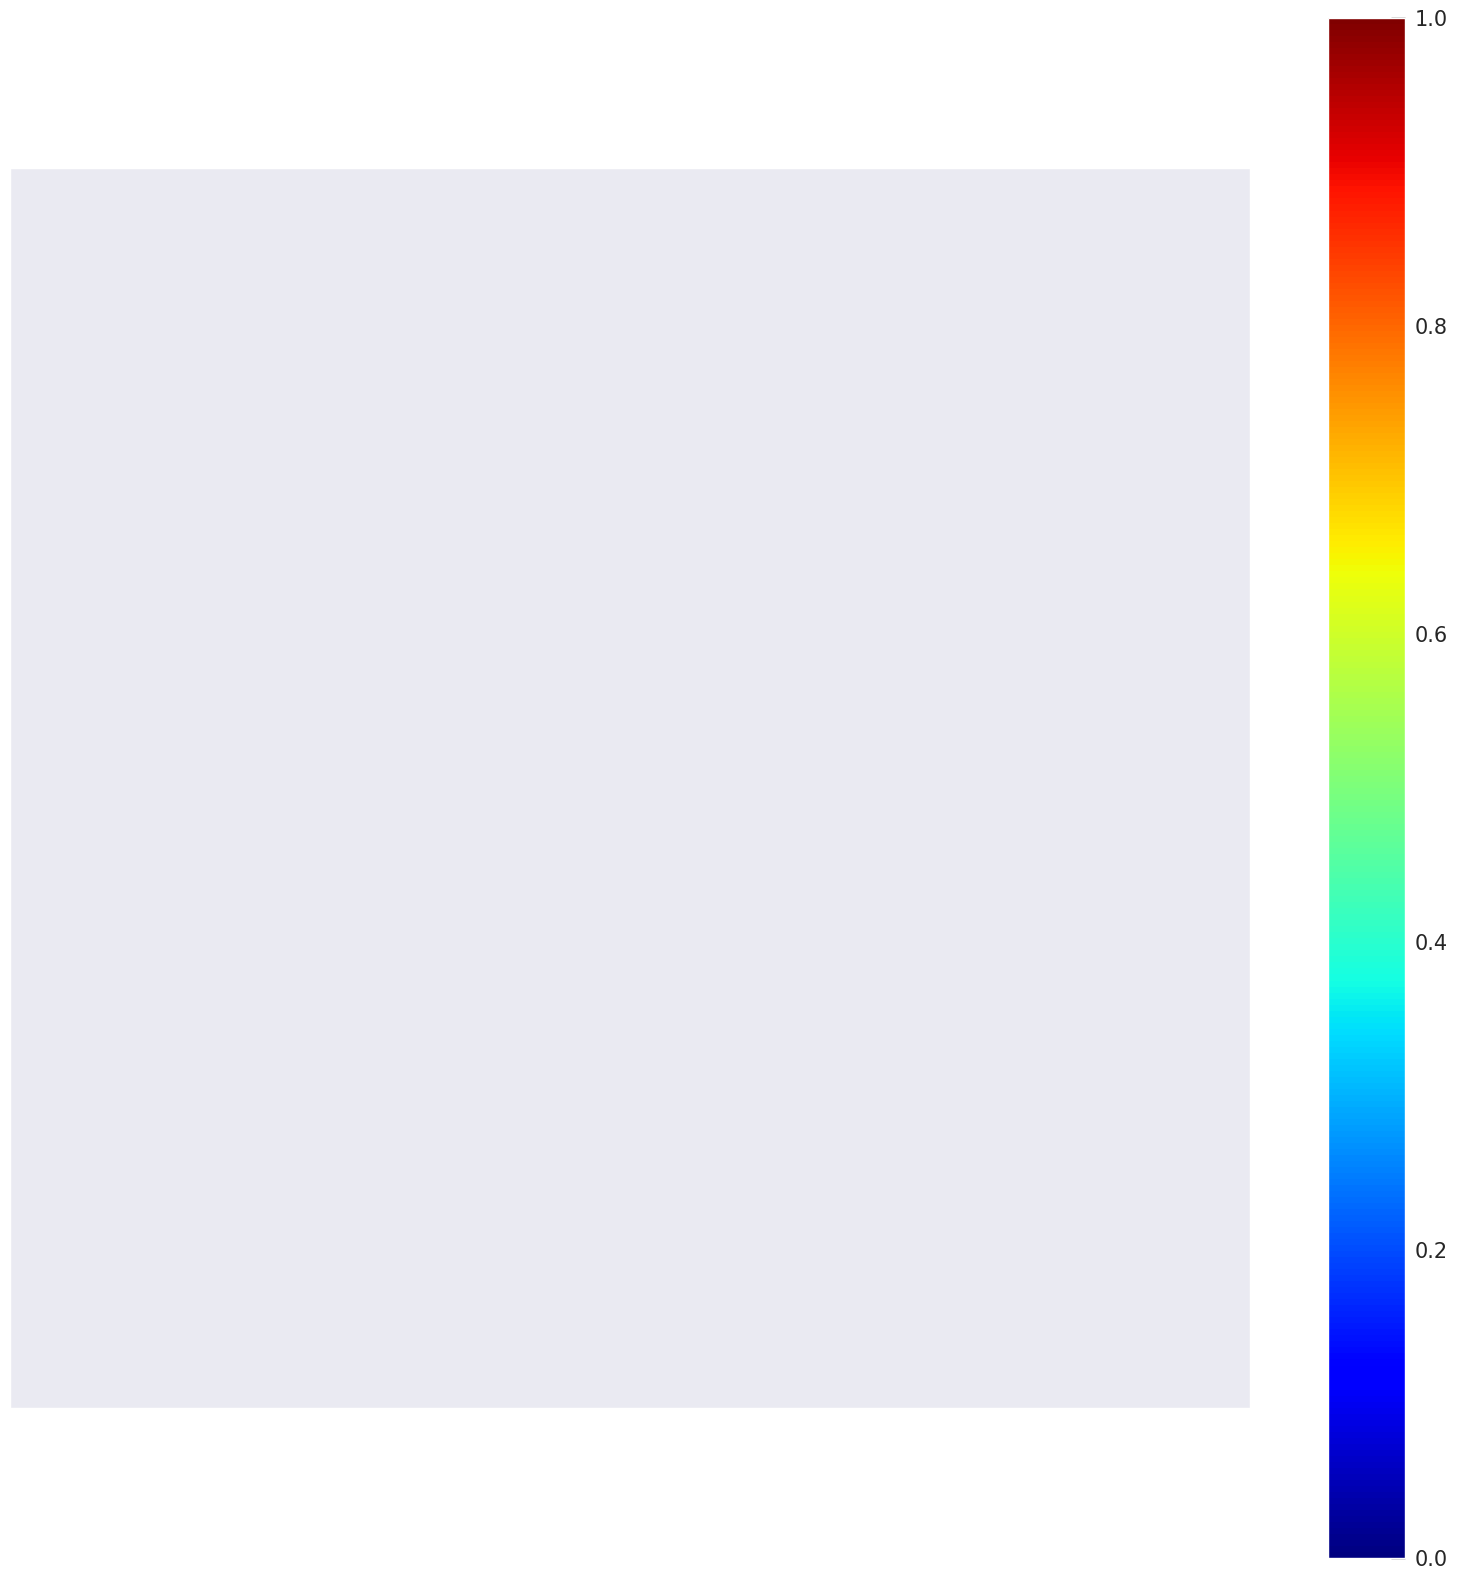

In [10]:
weight_paths = glob(os.path.join("/workspace/grokking/0927/exp3/mlp","*"))
total_masks = {}
for weight_path in weight_paths:
    if not "2seed" in weight_path:
        continue
    weight_path = os.path.join(weight_path,"0.pth")
    name = weight_path.split("/")[-2].split("_")[-1]
    config = Exp()
    model = OnlyMLP(num_layers=config.num_layers, d_vocab=config.d_vocab, \
                            d_model=config.d_model, d_emb=config.d_emb, \
                            act_type=config.act_type,  use_ln=config.use_ln, \
                            weight_scale=config.weight_scale)
    model.load_state_dict(torch.load(weight_path)["model"])
    W_E_mask = model.state_dict()["embed.weight_mask"]
    W_inproj_mask = model.state_dict()["inproj.weight_mask"]
    W_outproj_mask = model.state_dict()["outproj.weight_mask"]
    W_U_mask = model.state_dict()["unembed.weight_mask"]
    total_mask = torch.cat([W_E_mask.view(-1), W_inproj_mask.view(-1), W_outproj_mask.view(-1), W_U_mask.view(-1)], dim=0)
    # print(total_mask.shape)
    total_masks[name] = total_mask
jaccard_dis = torch.zeros((len(total_masks), len(total_masks)))
for i, (name1, mask1) in enumerate(total_masks.items()):
    for j, (name2, mask2) in enumerate(total_masks.items()):
        jaccard_dis[i][j] = jaccard_distance(mask1, mask2)

plt.figure(figsize=(20,20))
plt.imshow(jaccard_dis.numpy(), cmap=cm.jet, interpolation='nearest')
plt.grid(False)
plt.colorbar()
plt.xticks(np.arange(len(total_masks)), total_masks.keys(), rotation=90, fontsize=30)
plt.yticks(np.arange(len(total_masks)), total_masks.keys(), fontsize=30)
#plt.title("Jaccard Distance", fontsize=４0)
plt.savefig("jacard_distance.png")
plt.show()

os.makedirs("/home/mask_sim", exist_ok=True)
np.save("/home/mask_sim/jacard_distance.npy", jaccard_dis.numpy())


In [28]:
jaccard_dis = np.insert(jaccard_dis.numpy(), 0, jaccard_dis.numpy()[0], axis=0)

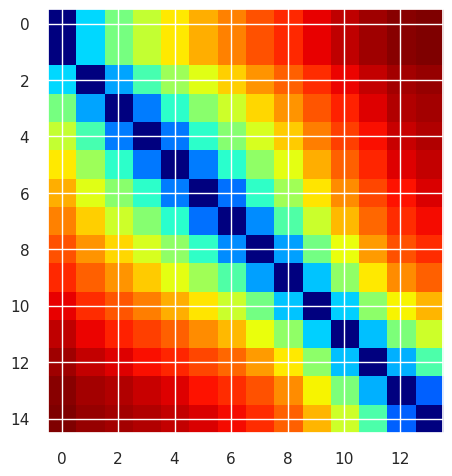

In [29]:
plt.imshow(jaccard_dis, cmap=cm.jet, interpolation='nearest')

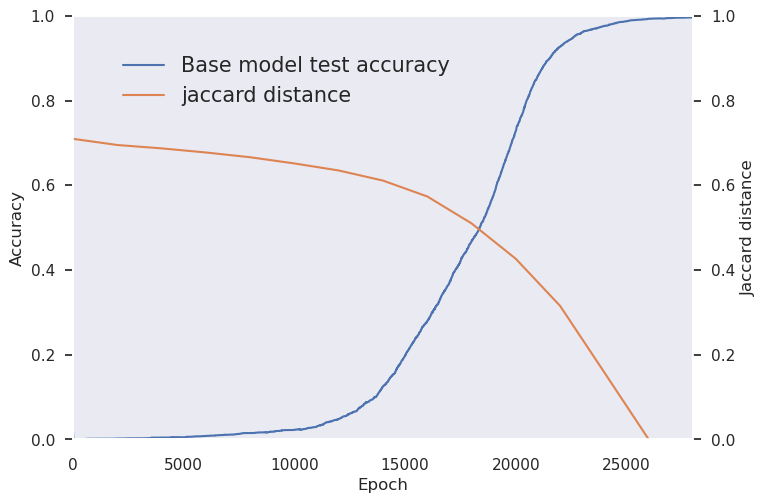

In [30]:
path  = "/workspace/grokking/exp0_mlp_test.csv"

df1 = pd.read_csv(path)
# print(jaccard_dis.numpy()[-1])
epochs = np.arange(0, (len(jaccard_dis[-1]))*2000, 2000)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ln1=ax1.plot(df1["Step"], df1["Grouped runs - test_acc"],"C0", label="Base model test accuracy")


ax2 = ax1.twinx()
ln2=ax2.plot(epochs,jaccard_dis[-1],"C1",label="jaccard distance" )

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left', bbox_to_anchor=(0.05, 0.95),fontsize=15)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Jaccard distance')
ax1.set_ylim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax1.set_xlim([0, 28000])
ax2.set_xlim([0, 28000])
ax1.grid(False)
ax2.grid(False)



#plt.savefig("fig/exp0_mlp.png", dpi=300, bbox_inches='tight')


# weight similarity

In [46]:
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
def weight_similarity(x, y):
    total_similarity = 0
    for w1,w2 in zip(x.values(),y.values()):
        # cos similarity
        cos = nn.CosineSimilarity(dim=0, eps=1e-6)
        total_similarity += cos(w1.view(-1), w2.view(-1)).mean()
        #cos(w1.view(-1), w2.view(-1)) / (torch.norm(w1.view(-1)) * torch.norm(w2.view(-1))).mean()
    return total_similarity/len(x)
        

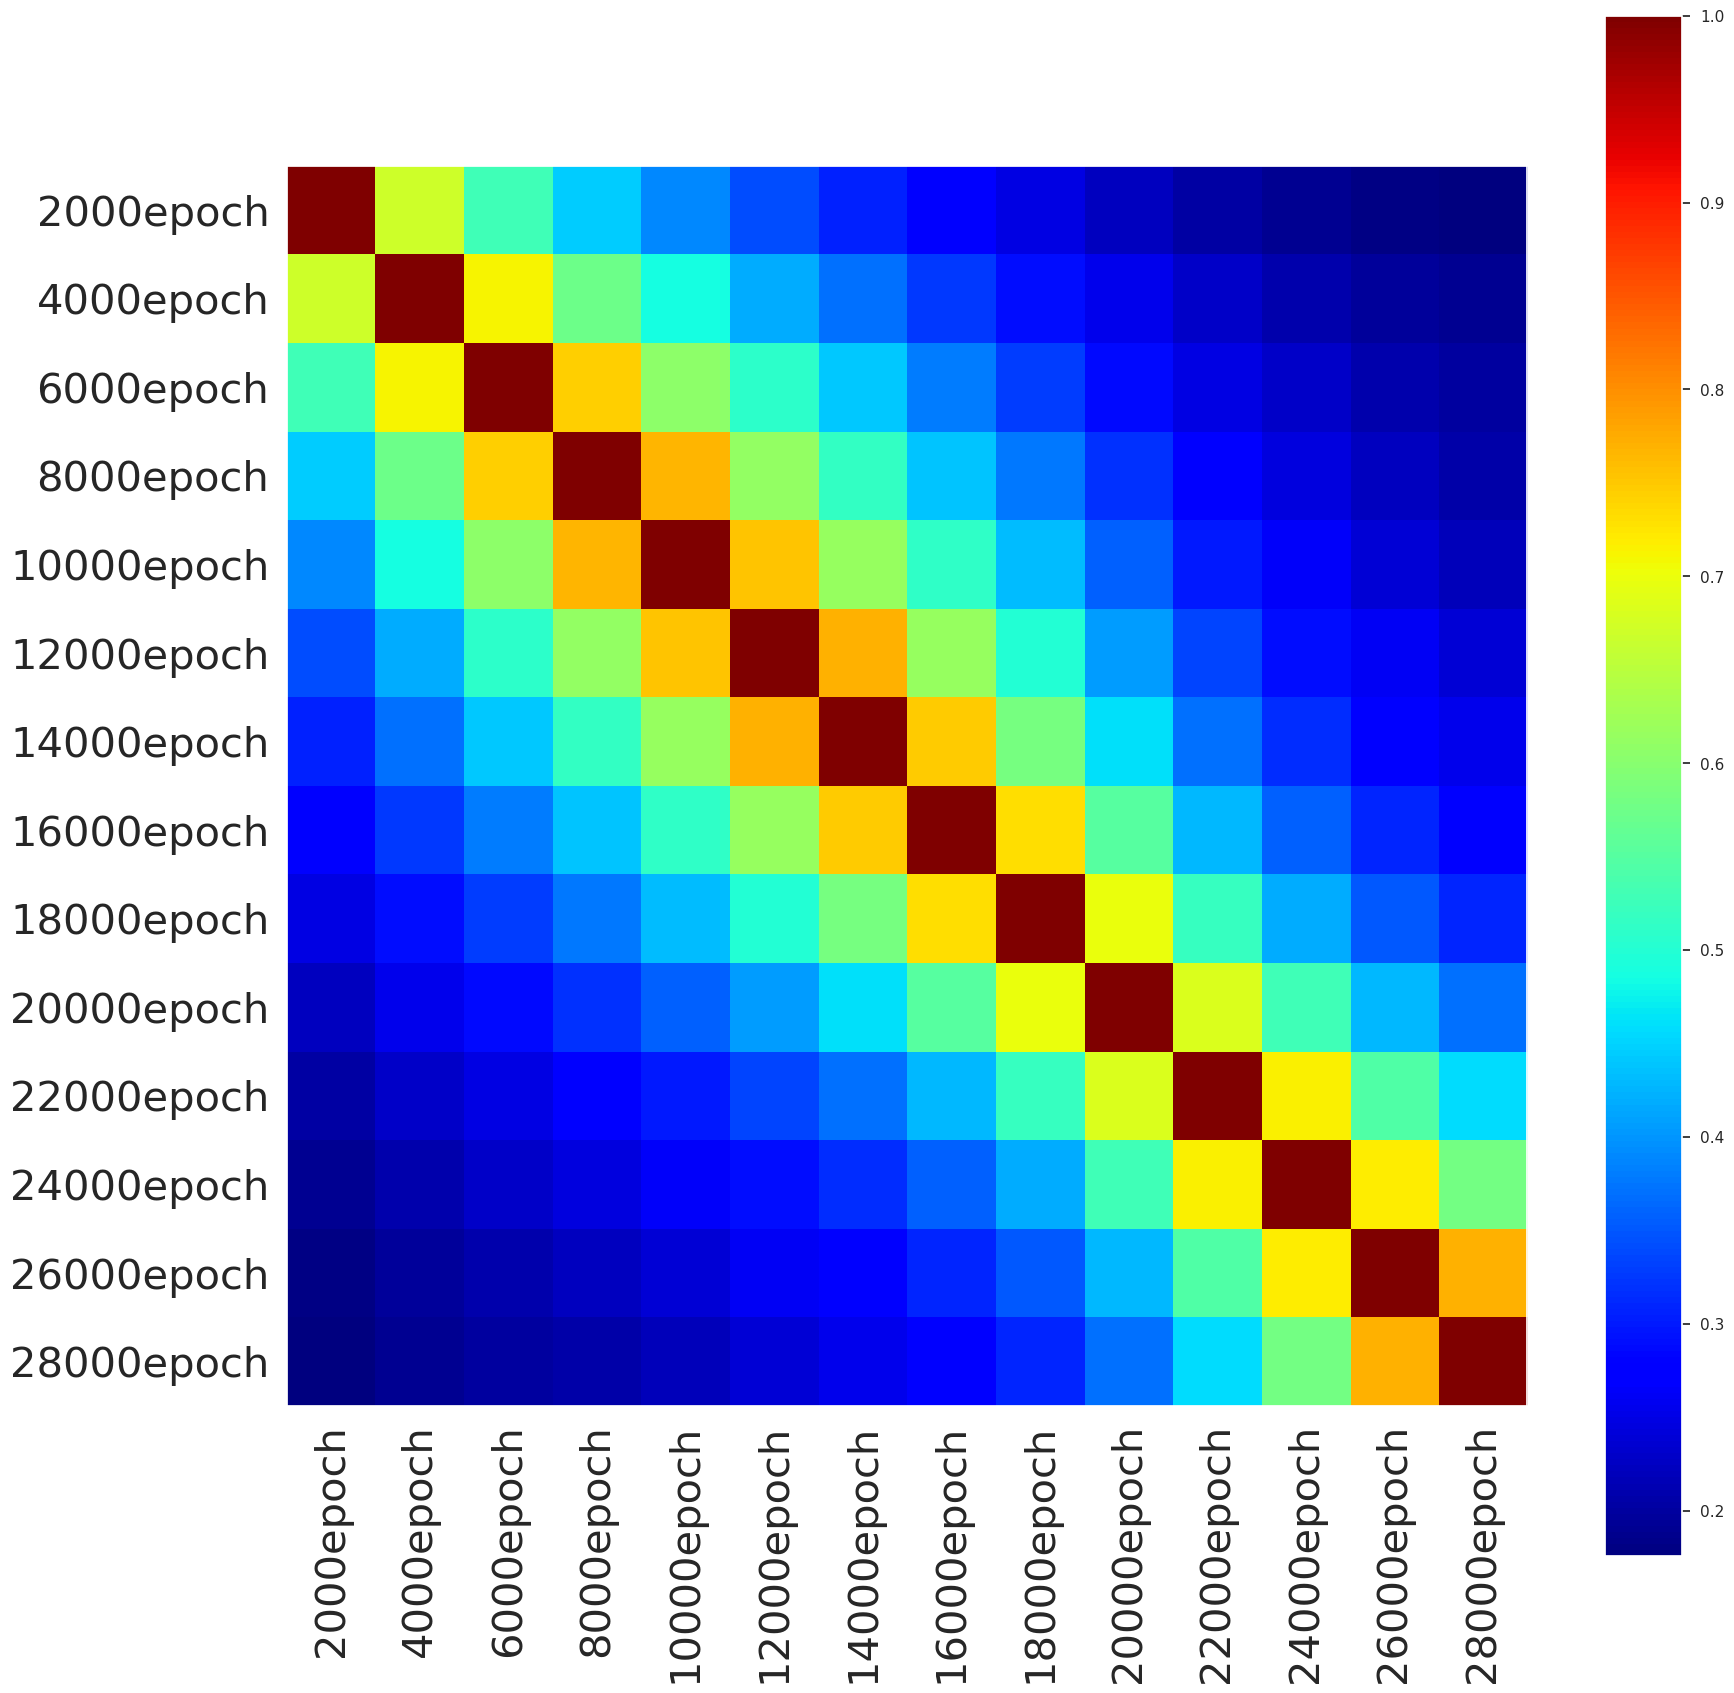

In [58]:
weight_paths = glob(os.path.join("/workspace/grokking/0927/exp3/mlp","*"))
total_weights = {}
total_masks = {}
for weight_path in weight_paths:
    if not "2seed" in weight_path:
        continue
    weight_path = os.path.join(weight_path,"0.pth")
    name = weight_path.split("/")[-2].split("_")[-1]
    if "final" in name :
        continue
    config = Exp()
    model = OnlyMLP(num_layers=config.num_layers, d_vocab=config.d_vocab, \
                            d_model=config.d_model, d_emb=config.d_emb, \
                            act_type=config.act_type,  use_ln=config.use_ln, \
                            weight_scale=config.weight_scale)
    model.load_state_dict(torch.load(weight_path)["model"])
    total_weights[name] = model.state_dict()
    W_E_mask = model.state_dict()["embed.weight_mask"]
    W_inproj_mask = model.state_dict()["inproj.weight_mask"]
    W_outproj_mask = model.state_dict()["outproj.weight_mask"]
    W_U_mask = model.state_dict()["unembed.weight_mask"]
    total_mask = torch.cat([W_E_mask.view(-1), W_inproj_mask.view(-1), W_outproj_mask.view(-1), W_U_mask.view(-1)], dim=0)
    # print(total_mask.shape)
    total_masks[name] = total_mask

weight_sim = torch.zeros((len(total_weights), len(total_weights)))
for i, (name1, weight1) in enumerate(total_weights.items()):
    for j, (name2, weight2) in enumerate(total_weights.items()):
        weight_sim[i][j] = weight_similarity(weight1, weight2) * (1- jaccard_dis[i][j])

plt.figure(figsize=(20,20))
plt.imshow(weight_sim, cmap=cm.jet, interpolation='nearest')
plt.grid(False)
plt.colorbar()
plt.xticks(np.arange(len(total_weights)), total_masks.keys(), rotation=90, fontsize=30)
plt.yticks(np.arange(len(total_weights)), total_masks.keys(), fontsize=30)
#plt.title("Jaccard Distance", fontsize=４0)
plt.savefig("weight_sim.png")
plt.show()


tensor([0.7575, 0.7420, 0.7312, 0.7206, 0.7063, 0.6870, 0.6695, 0.6468, 0.6121,
        0.5547, 0.4702, 0.3611, 0.1950, 0.0000])


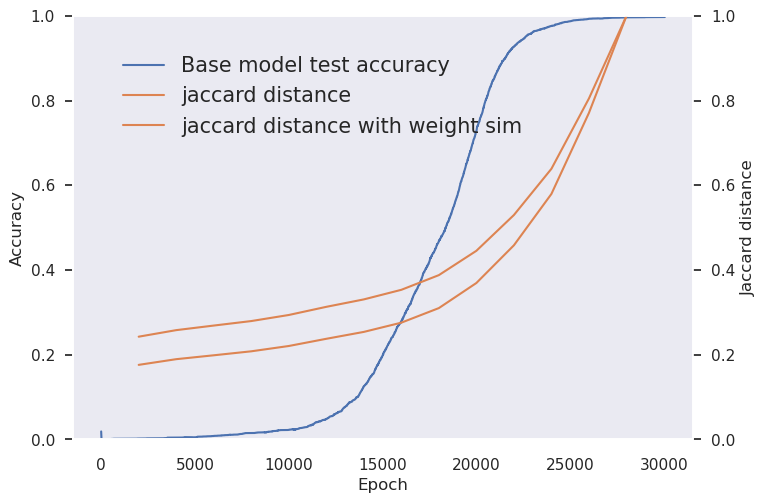

In [60]:
path  = "/workspace/grokking/exp0_mlp_test.csv"

df1 = pd.read_csv(path)
print(jaccard_dis[-1])
epochs = np.arange(2000, (len(jaccard_dis[-1])+1)*2000, 2000)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ln1=ax1.plot(df1["Step"], df1["Grouped runs - test_acc"],"C0", label="Base model test accuracy")


ax2 = ax1.twinx()
ln2=ax2.plot(epochs,1 - jaccard_dis[-1],"C1",label="jaccard distance" )
ln2=ax2.plot(epochs,weight_sim[-1],"C1",label="jaccard distance with weight sim" )

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='upper left', bbox_to_anchor=(0.05, 0.95),fontsize=15)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Jaccard distance')
ax1.set_ylim([0.0, 1.0])
ax2.set_ylim([0.0, 1.0])
ax1.grid(False)
ax2.grid(False)

{'2k': tensor([0., 1., 0.,  ..., 0., 1., 0.]), '4k': tensor([0., 1., 0.,  ..., 1., 1., 0.]), '6k': tensor([0., 1., 0.,  ..., 1., 1., 0.]), '8k': tensor([0., 0., 0.,  ..., 1., 1., 0.]), '1k0': tensor([0., 0., 0.,  ..., 1., 1., 0.]), '12k': tensor([0., 0., 0.,  ..., 1., 1., 0.]), '14k': tensor([0., 0., 0.,  ..., 1., 1., 0.]), '16k': tensor([0., 0., 0.,  ..., 1., 1., 0.]), '18k': tensor([0., 0., 0.,  ..., 1., 1., 0.]), '2k0': tensor([0., 0., 0.,  ..., 1., 1., 0.]), '22k': tensor([0., 0., 0.,  ..., 1., 1., 0.]), '24k': tensor([0., 0., 1.,  ..., 1., 1., 1.]), '26k': tensor([0., 0., 0.,  ..., 0., 0., 1.]), '28k': tensor([0., 0., 0.,  ..., 0., 0., 1.])}
{'2k': tensor([0., 0., 0.,  ..., 1., 0., 1.]), '4k': tensor([0., 0., 1.,  ..., 1., 0., 1.]), '6k': tensor([0., 0., 0.,  ..., 0., 0., 1.]), '8k': tensor([0., 0., 0.,  ..., 0., 0., 1.]), '1k0': tensor([0., 0., 0.,  ..., 0., 0., 1.]), '12k': tensor([0., 1., 0.,  ..., 0., 0., 1.]), '14k': tensor([0., 1., 0.,  ..., 0., 0., 1.]), '16k': tensor([0., 

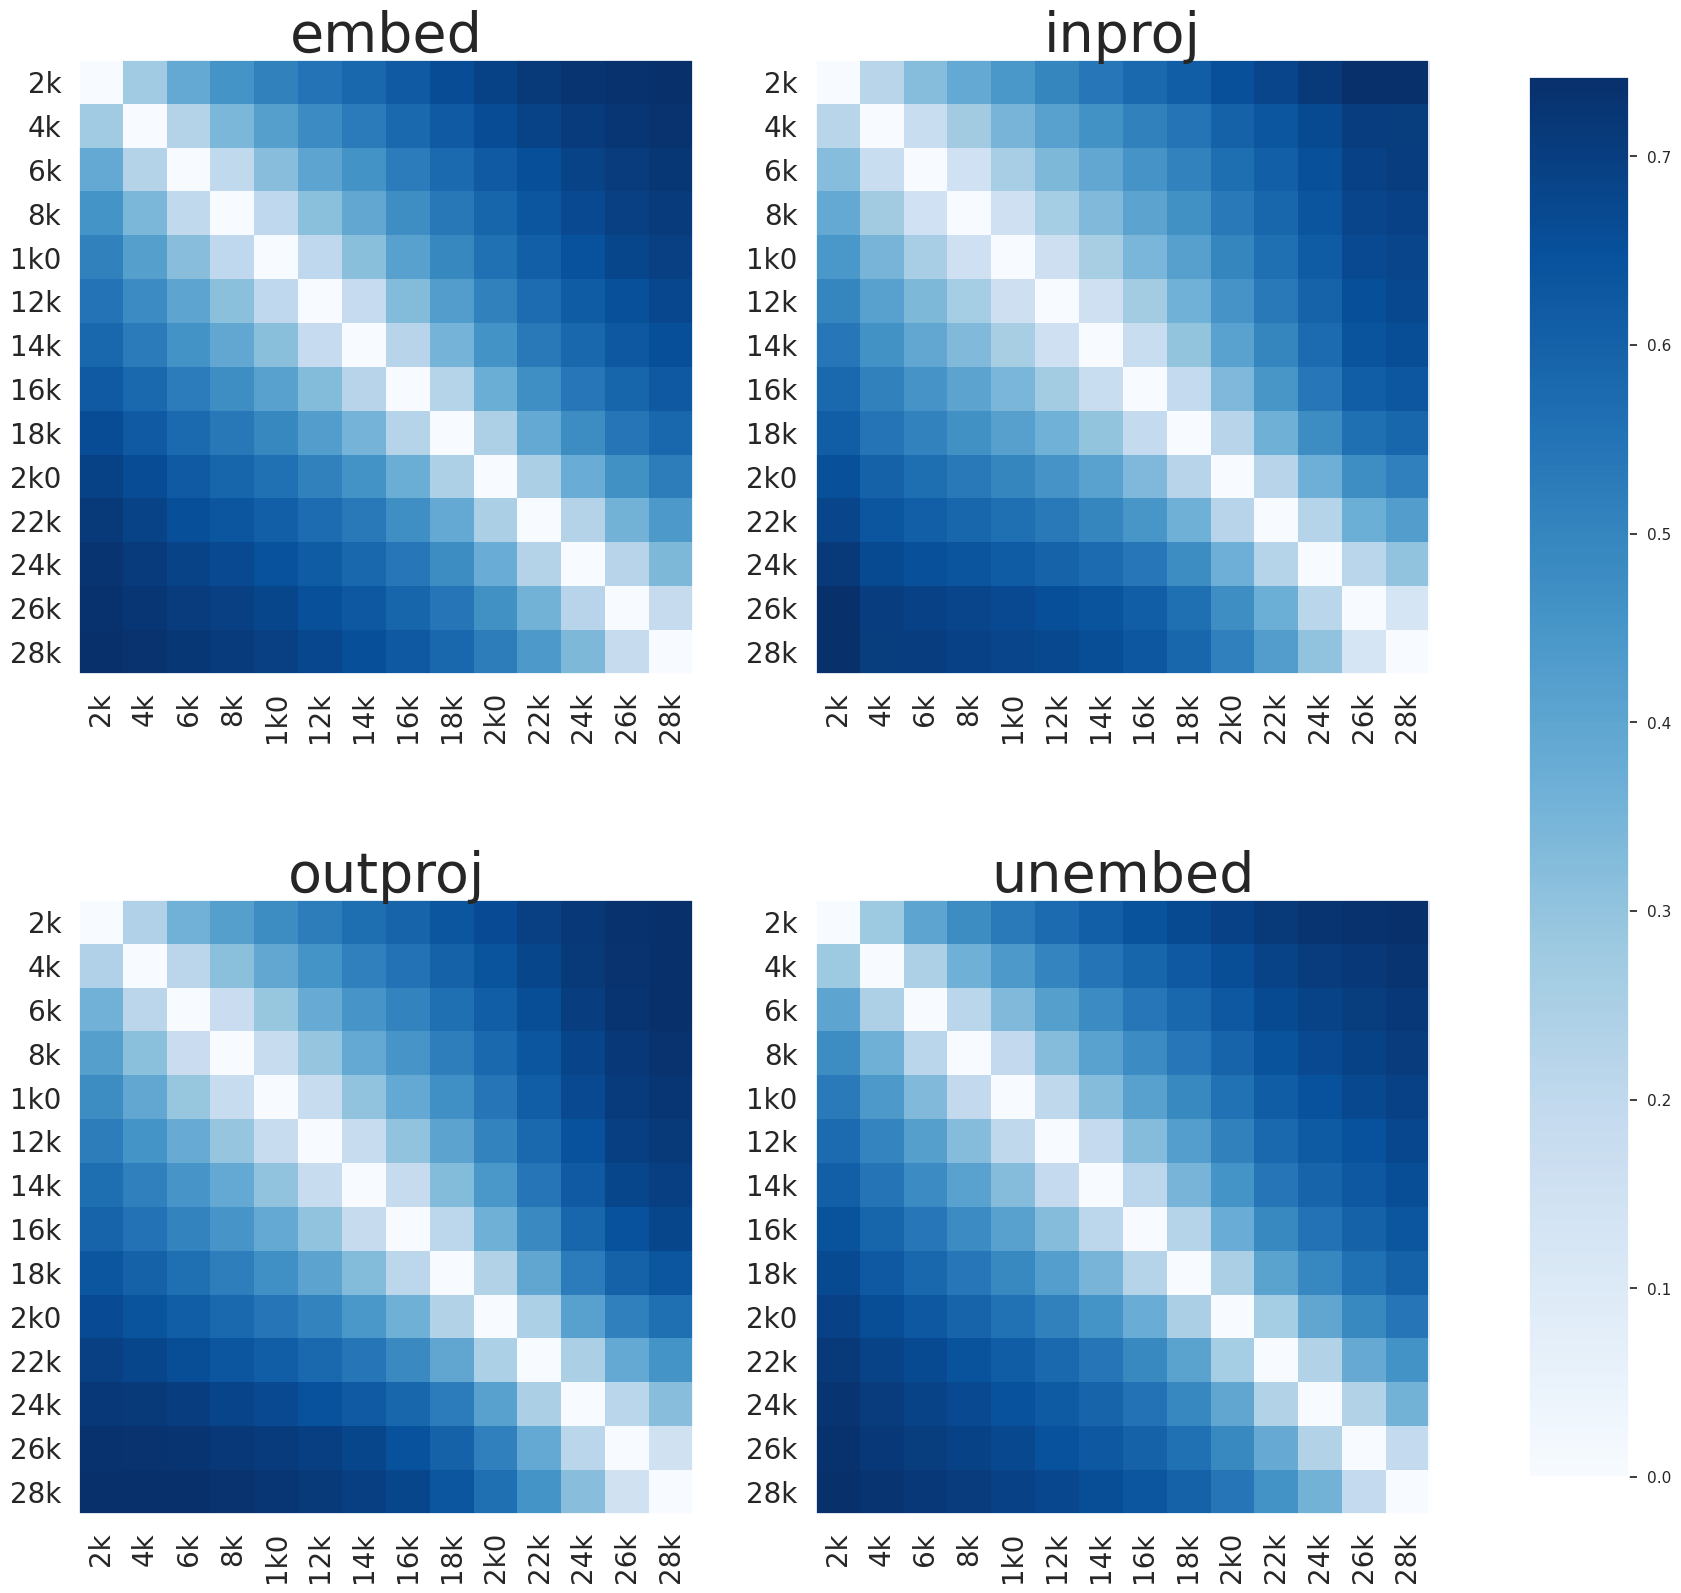

In [39]:


weight_paths = glob(os.path.join("/workspace/grokking/0927/exp3/mlp","*"))
fig, ax = plt.subplots(2,2, figsize=(20,20))
jaccard_distance_layer = {}
for layer_i, layer in enumerate(["embed", "inproj", "outproj", "unembed"]):
    total_masks = {}    
    for weight_path in weight_paths:
        if not "2seed" in weight_path:
            continue
        weight_path = os.path.join(weight_path,"0.pth")
        name = weight_path.split("/")[-2].split("_")[-1].replace("epoch", "").replace("000", "k")
        if "final" in name :
            continue
        config = Exp()
        model = OnlyMLP(num_layers=config.num_layers, d_vocab=config.d_vocab, \
                                d_model=config.d_model, d_emb=config.d_emb, \
                                act_type=config.act_type,  use_ln=config.use_ln, \
                                weight_scale=config.weight_scale)
        model.load_state_dict(torch.load(weight_path)["model"])
        W_mask = model.state_dict()[f"{layer}.weight_mask"]
        total_masks[name] = W_mask.view(-1)
    print(total_masks)
    jaccard_dis = torch.zeros((len(total_masks), len(total_masks)))
    for i, (name1, mask1) in enumerate(total_masks.items()):
        for j, (name2, mask2) in enumerate(total_masks.items()):
            jaccard_dis[i][j] = jaccard_distance(mask1, mask2)
    jaccard_distance_layer[layer] = jaccard_dis.numpy()
    ax[layer_i//2][layer_i%2].imshow(jaccard_dis.numpy(), cmap=cm.Blues, interpolation='nearest')
    ax[layer_i//2][layer_i%2].grid(False)
    ax[layer_i//2][layer_i%2].set_xticks(np.arange(len(total_masks)))
    ax[layer_i//2][layer_i%2].set_yticks(np.arange(len(total_masks)))
    ax[layer_i//2][layer_i%2].set_xticklabels(total_masks.keys(), rotation=90, fontsize=20)
    ax[layer_i//2][layer_i%2].set_yticklabels(total_masks.keys(), fontsize=20)
    ax[layer_i//2][layer_i%2].set_title(f"{layer}", fontsize=40)
    #plt.title("Jaccard Distance", fontsize=４0)
# colorbar
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(ax[0][0].imshow(jaccard_distance_layer["embed"], cmap=cm.Blues, interpolation='nearest'), cax=cbar_ax)
torch.save(jaccard_distance_layer, "/home/mask_sim/jaccard_distance_layer.pth")
plt.savefig("jacard_distance.png")
plt.show()




# plt.figure(figsize=(20,20))
# plt.imshow(jaccard_dis.numpy(), cmap=cm.jet, interpolation='nearest')
# plt.grid(False)
# plt.colorbar()
# plt.xticks(np.arange(len(total_masks)), total_masks.keys(), rotation=90, fontsize=30)
# plt.yticks(np.arange(len(total_masks)), total_masks.keys(), fontsize=30)
# #plt.title("Jaccard Distance", fontsize=４0)
# plt.savefig("jacard_distance.png")
# plt.show()

# os.makedirs("/home/mask_sim", exist_ok=True)
# np.save("/home/mask_sim/jacard_distance.npy", jaccard_dis.numpy())

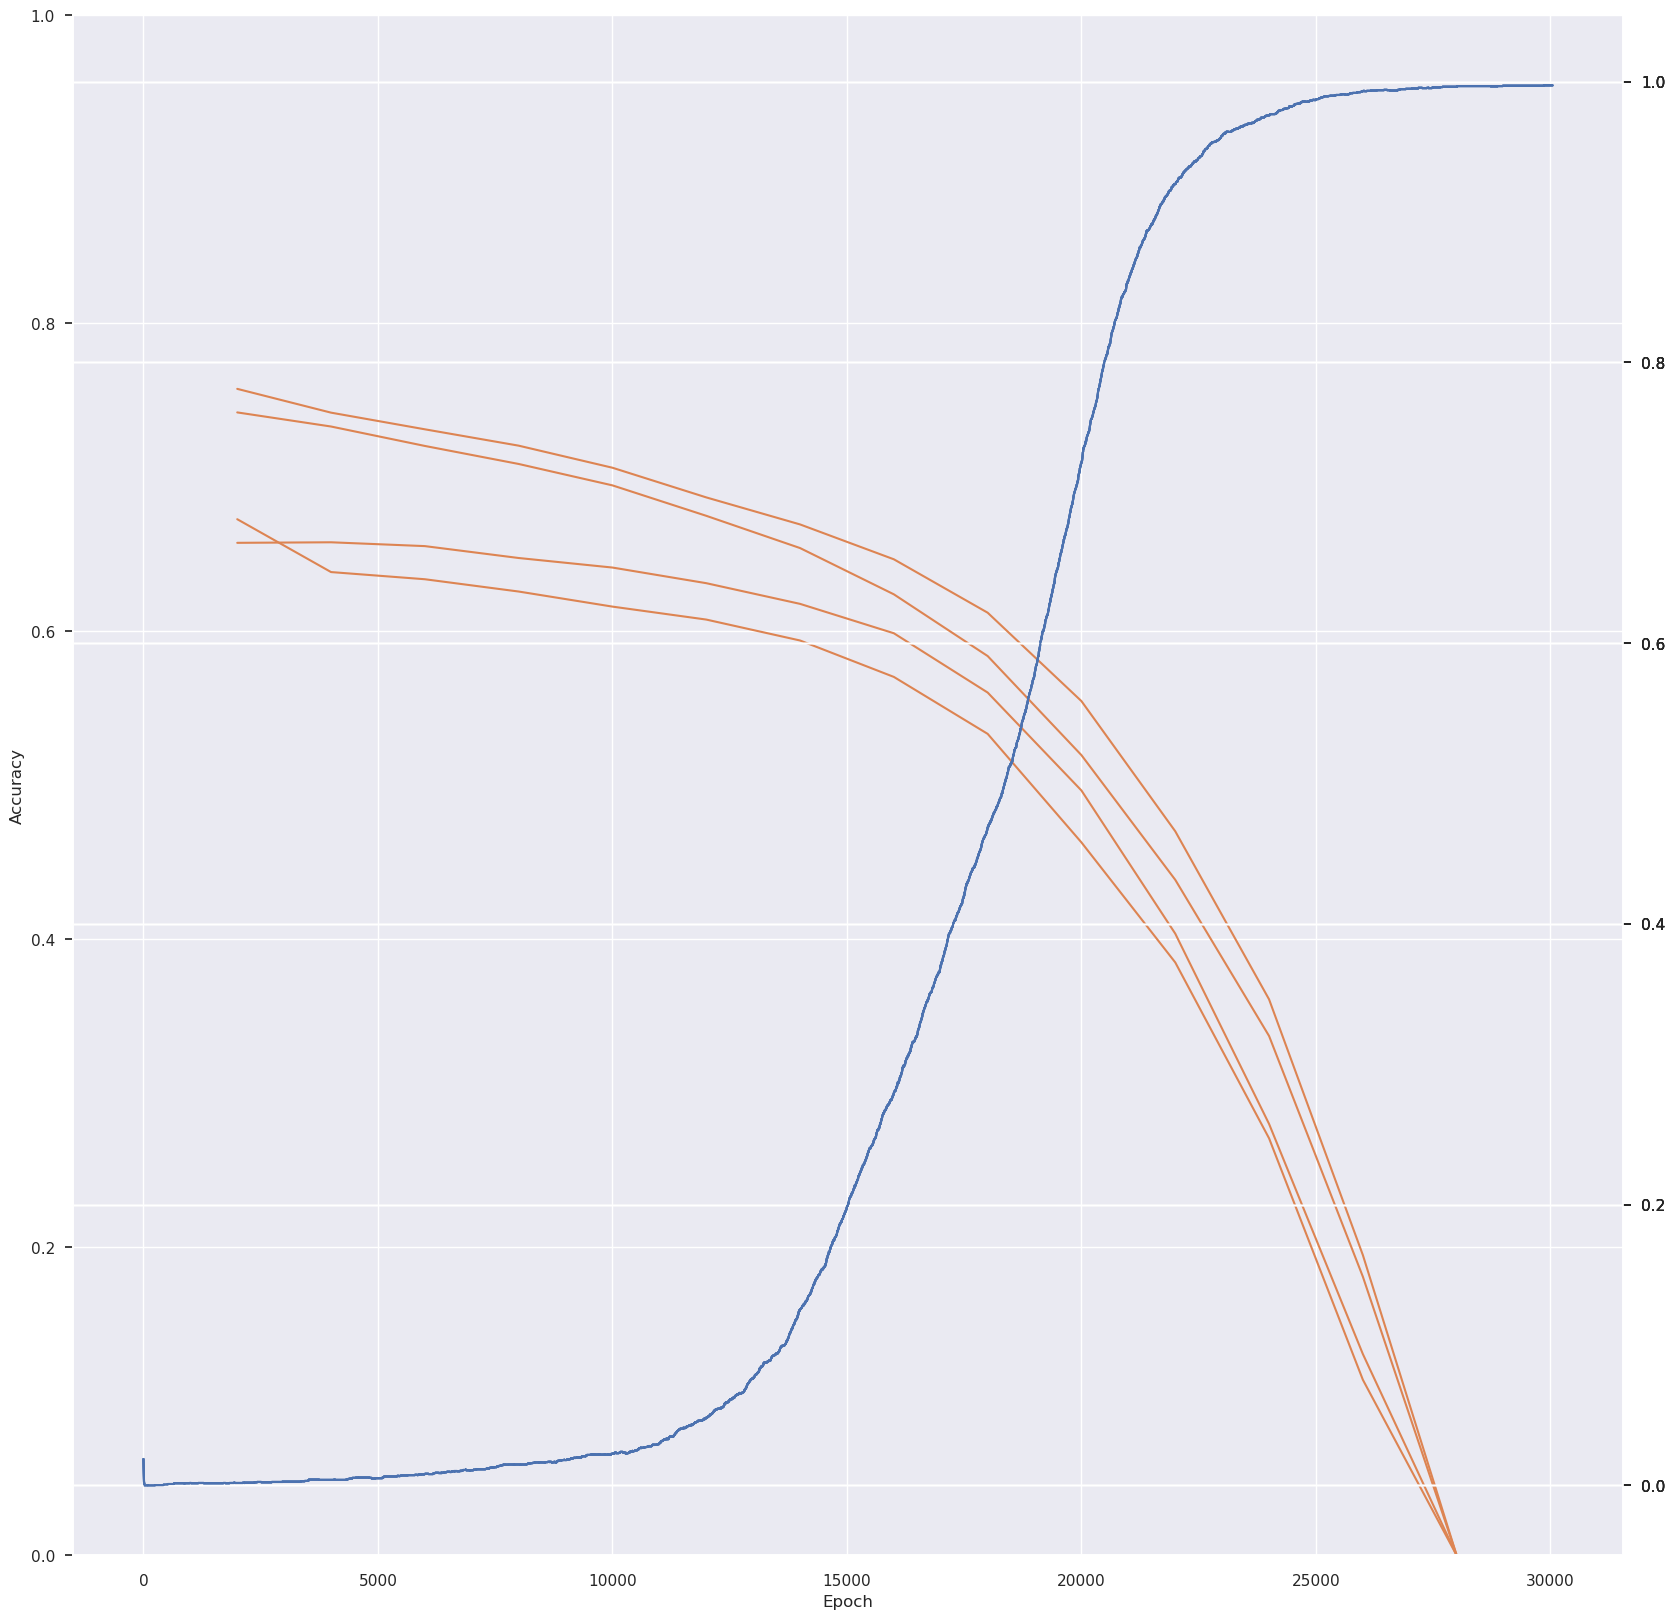

In [35]:
path  = "/workspace/grokking/exp0_mlp_test.csv"
df1 = pd.read_csv(path)

epochs = np.arange(2000, (len(jaccard_dis.numpy()[-1])+1)*2000, 2000)
fig, ax = plt.subplots(1,1, figsize=(20,20))
for i, (layer, jacard_dis) in enumerate(jaccard_distance_layer.items()):
    ax.plot(epochs,jacard_dis[-1],"C1",label="jaccard distance" )
    ax2 = ax.twinx()
    ax2.plot(df1["Step"], df1["Grouped runs - test_acc"],"C0", label="Base model test accuracy")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    ax.set_ylim([0.0, 1.0])
    #plt.title("Jaccard Distance", fontsize=４0)


In [34]:
torch.save(jaccard_distance_layer, "/home/mask_sim/jaccard_distance_layer.pth")

## batch

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

6
[0.0, 0.5157816410064697, 0.5380240678787231, 0.5522996187210083, 0.5604466795921326, 0.5674684643745422]


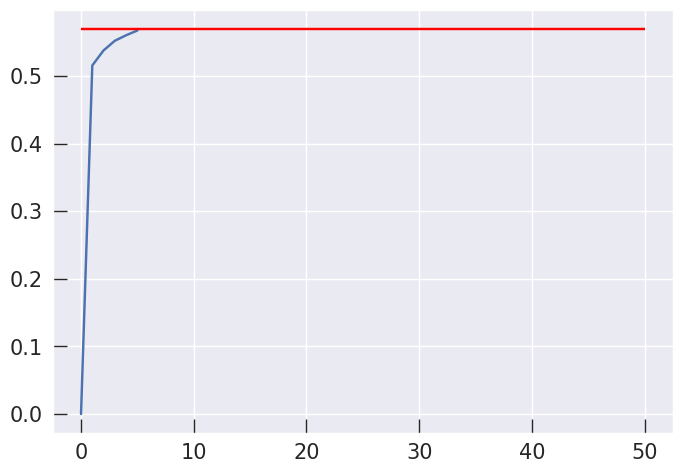

In [59]:
config = Exp()
jd_list = []
for i in range(6):
    epoch = i*200
    model1 = OnlyMLP(num_layers=config.num_layers, d_vocab=config.d_vocab, \
                            d_model=config.d_model, d_emb=config.d_emb, \
                            act_type=config.act_type,  use_ln=config.use_ln, \
                            weight_scale=config.weight_scale)
    model1.load_state_dict(torch.load(f"/workspace/Neurips_rebuttal/batch1/WIDTH_48/{epoch}.pth")["model"])
    model2 = OnlyMLP(num_layers=config.num_layers, d_vocab=config.d_vocab, \
                                d_model=config.d_model, d_emb=config.d_emb, \
                                act_type=config.act_type,  use_ln=config.use_ln, \
                                weight_scale=config.weight_scale)
    model2.load_state_dict(torch.load(f"/workspace/Neurips_rebuttal/batch5/WIDTH_48/{epoch}.pth")["model"])

    #magnitude pruning
    prune_rate = 0.4
    jaccard_dis = 0
    for layer in ["embed.W_E", "inproj.W", "outproj.W", "unembed.W_U"]:
        W1 = model1.state_dict()[f"{layer}"]
        W2 = model2.state_dict()[f"{layer}"]
        score1 = torch.clone(W1.data).detach().abs_()
        score2 = torch.clone(W2.data).detach().abs_()
        mask1 = torch.where(score1>torch.quantile(score1, prune_rate), 1, 0)
        mask2 = torch.where(score2>torch.quantile(score2, prune_rate), 1, 0)
        jaccard_dis += jaccard_distance(mask1, mask2)

        random_score1 = torch.randn_like(W1)
        random_score2 = torch.randn_like(W2)
        mask_random1 = torch.where(random_score1>torch.quantile(random_score1, prune_rate), 1, 0)
        mask_random2 = torch.where(random_score2>torch.quantile(random_score2, prune_rate), 1, 0)
        random_dis = jaccard_distance(mask_random1, mask_random2)
        # jaccard_dis += jaccard_distance(mask1, mask_random)
    jd_list.append((jaccard_dis/4).item())

    # if i%10 == 0:
        # plt.imshow(score1.numpy(), cmap=cm.jet, interpolation='nearest')
        # plt.colorbar()
        # plt.show()
        # plt.imshow(score2.numpy(), cmap=cm.jet, interpolation='nearest')
        # plt.colorbar()
        # plt.show()
print(len(jd_list))
print(jd_list)
plt.plot(jd_list)
plt.hlines(random_dis, 0, 50, color="red")
plt.show()

In [19]:
model1.state_dict().keys()

odict_keys(['unembed.W_U', 'unembed.weight_mask', 'embed.W_E', 'embed.weight_mask', 'inproj.W', 'inproj.weight_mask', 'outproj.W', 'outproj.weight_mask'])